In [37]:
# -*- coding: utf-8 -*-
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # pandas is a library for handling datasets
import os # to move around your operating system
import scipy as sp  # scientific computation library

from mpl_toolkits.mplot3d import axes3d # in case we need to plot in 3D z=f(x,y)
import seaborn as sns  # another package for pretty graphs

# Scikit-learn (sklearn) is a powerful and fairly comprehensive library of ML algorithms
from sklearn import datasets
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets

np.random.seed(13) # a seed ensures that re-running the random number generator yields the same outcome
# this is helpful for the purpose of sanity checking your implementations

In [38]:
# 4 - generating synthetic data set
def f(x):
    y = []
    for i in range(len(x)):
        e = np.random.normal(0,0.1)
        y.append(np.sin(4*np.pi*x[i]) + e)
    
    return np.array(y)

# N points chosen randomly from 0 to 1
N = 1000
rn = np.random.uniform(0, 1, N) 
x = np.reshape(np.sort(rn, axis=0), (N, 1)) #sorts rn from low to high and converts array from 1xN to Nx1

In [39]:
# Rescaling data - x - centred about 0
x_scaled = x - x.mean()

#splitting scaled data into train and test sets
x_train_scaled, x_test_scaled = train_test_split(x_scaled, test_size=0.33, random_state=42)
x_train_scaled = np.sort(x_train_scaled, axis=0) #sorts x_train from low to high
x_test_scaled = np.sort(x_test_scaled, axis=0) #sorts x_test from low to high

In [40]:
#generating corresponding y components of scaled train and test sets
y_train_scaled = f(x_train_scaled) 
y_test_scaled =  f(x_test_scaled) 

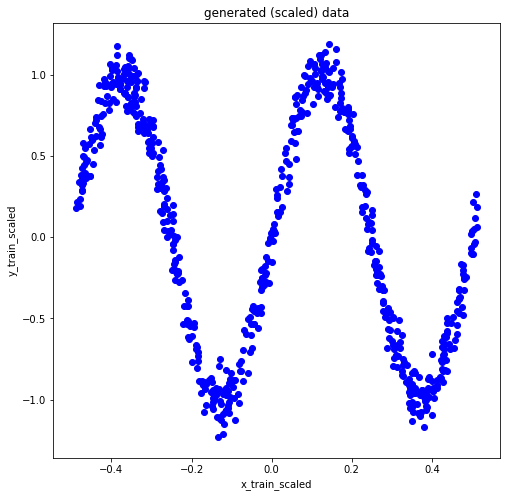

In [53]:
# plotting rescaled training data
fig, ax = plt.subplots(figsize=(8,8),nrows=1, ncols=1)
ax.set(xlabel="x_train_scaled", ylabel="y_train_scaled", title = "generated (scaled) data")
ax.scatter(x_train_scaled, y_train_scaled, c='b', label='scaled data')

In [42]:
# 4.1 linear regression with polynomials and radial basis functions
def gauss_basis_fn(x, mu, sigma=0.1):
    return np.exp(-0.5 * (((mu - x) ** 2) / (sigma ** 2)))  #returns column of design matrix
      
def poly_basis_fn(x, degree):
    return x ** degree
    #returns column of design matrix corresponding to the entered degree

In [43]:
#defining design matrices

def poly_design(X, degree):
    A = poly_basis_fn(X, 1) #np.ones_like(X)
    for j in range(2, degree+1): # jth power of polynomial j = 1,...,p
        A = np.hstack((A, poly_basis_fn(X, j)))
    return A

def gauss_design(X, p):
    x_j = np.random.uniform(X[0], X[np.size(X)-1], p)
    x_j_learnt.append(x_j[0]) 
    A = gauss_basis_fn(X, x_j[0]) #np.ones_like(X)
    for j in range(1, p): # jth power of polynomial j = 1,...,p
        A = np.hstack((A, gauss_basis_fn(X, x_j[j])))
        x_j_learnt.append(x_j[j]) 
    return A

def gauss_design_test(X, p, x_j): 
    A = gauss_basis_fn(X, x_j[0]) #np.ones_like(X)
    for j in range(1, p): # jth power of polynomial j = 1,...,p
        A = np.hstack((A, gauss_basis_fn(X, x_j[j])))
    return A

In [44]:
# calculating min weights
def calc_weights(A, lamda, y):
    t1 = np.matmul(A.T, A)
    t2 = lamda*np.identity(len(A.T))
    t3 = np.linalg.inv(t1 + t2)
    t4 = np.matmul(A.T, y)
    w_min = np.matmul(t3, t4) #min loss
    return w_min

In [45]:
#calculate the mse and rmse 
def error(y, A, w_min):
    mse = np.square(y-np.matmul(A, w_min)).mean()
    rmse = mse**0.5
    return mse, rmse

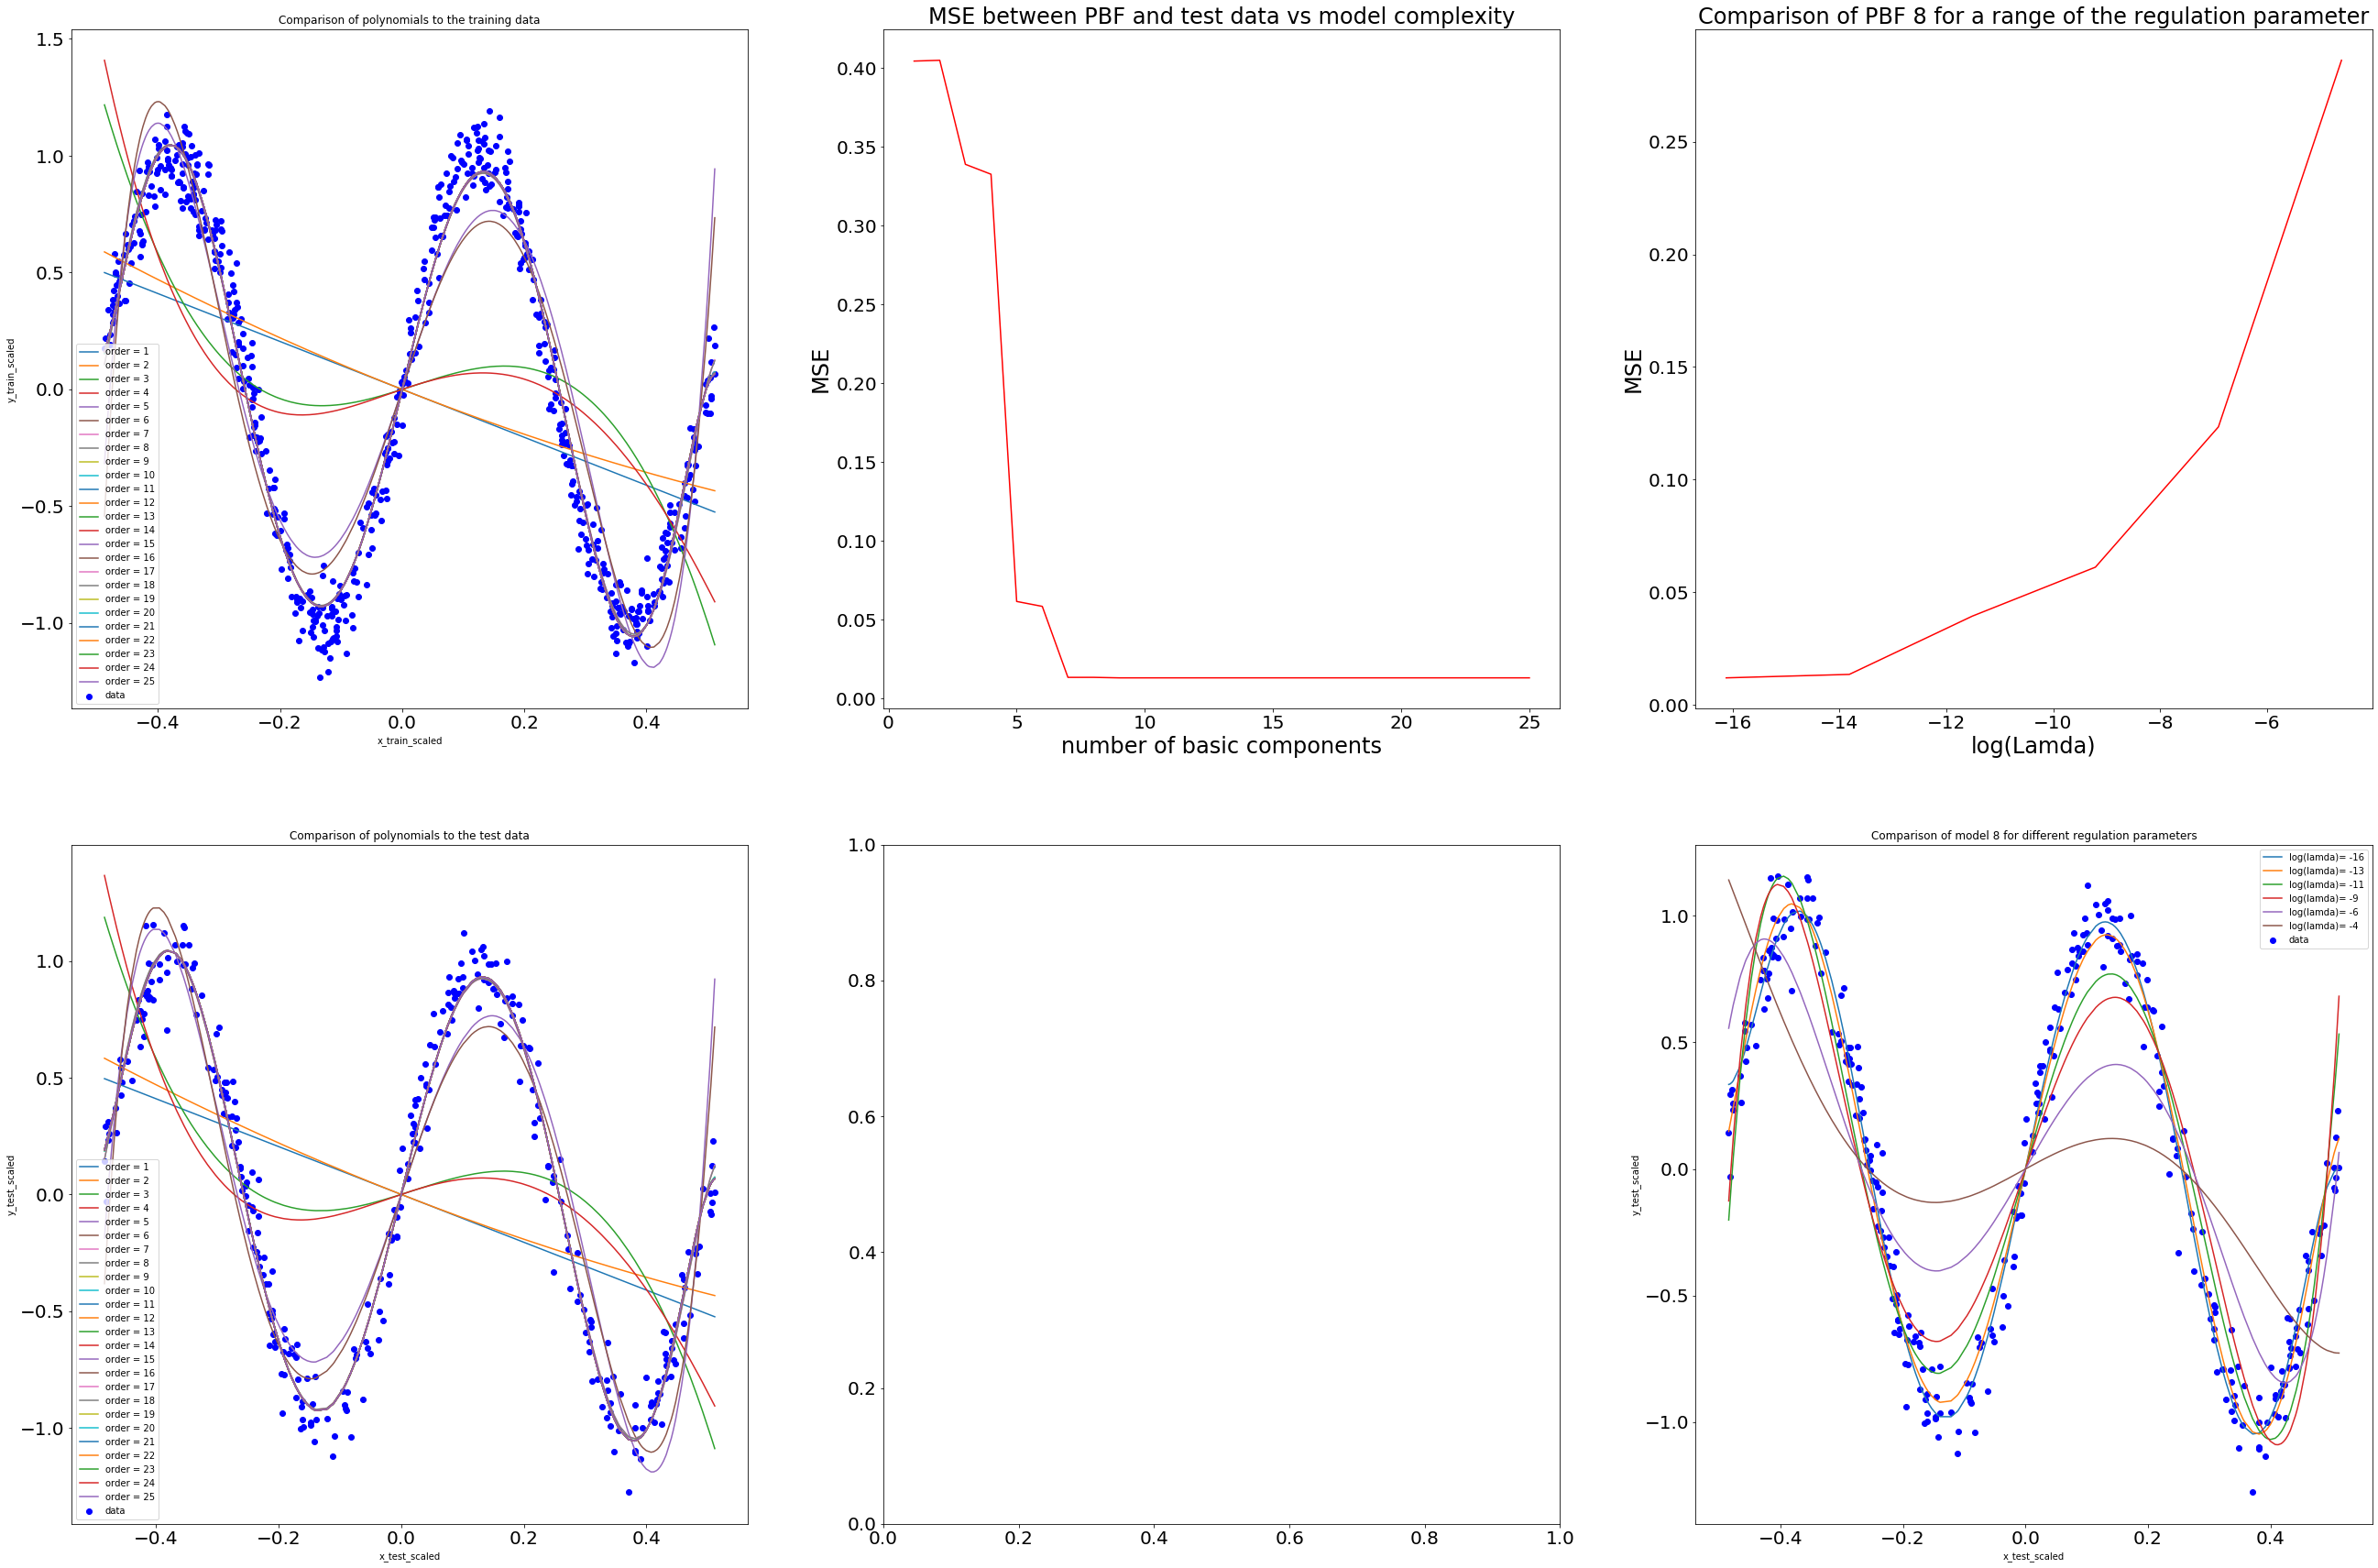

In [109]:
fig, ax = plt.subplots(figsize=(45,30),nrows=2, ncols=3)
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

# plotting polynomials
ax[0][0].set(xlabel="x_train_scaled", ylabel="y_train_scaled", title = "Comparison of polynomials to the training data")
ax[0][0].scatter(x_train_scaled, y_train_scaled, c='b', label='data')
ax[1][0].set(xlabel="x_test_scaled", ylabel="y_test_scaled", title = "Comparison of polynomials to the test data")
ax[1][0].scatter(x_test_scaled, y_test_scaled, c='b', label='data')
#ax[0][1].set(xlabel="number of basic components", ylabel="MSE")#, title = "MSE between PBF and test data vs model complexity")
ax[0][1].set_title(label="MSE between PBF and test data vs model complexity", fontsize=24)
ax[0][1].set_xlabel(xlabel="number of basic components", fontsize=24)
ax[0][1].set_ylabel(ylabel="MSE", fontsize=24)

degree_poly = 0
lamda_poly = 10**(-6) # regularisation parameter
v = 25 # number of polynomials to plot

order_poly = [i for i in range((degree_poly+1), (degree_poly+v+1))]
mse_poly = []

for i in range(v):
    degree_poly = degree_poly + 1
    A_poly_train = poly_design(x_train_scaled, degree_poly) #design matrix of training data
    A_poly_test = poly_design(x_test_scaled, degree_poly) #design matrix of test data
    w_poly = calc_weights(A_poly_train, lamda_poly, y_train_scaled)
    
    e_poly_train = error(y_train_scaled, A_poly_train, w_poly) #error between model and training data
    e_poly_test = error(y_test_scaled, A_poly_test, w_poly) #error between model and test data
    mse_poly.append(e_poly_test[0])
            
    #print("POLYNOMIALS")
    #print("Order: ", degree_poly)
    #print("weights: ", w_poly)
    #print("mse of training data: ", e_poly_train[0])
    #print("mse of test data: ", e_poly_test[0])
    #print(" ")
    ax[0][0].plot(x_train_scaled, np.matmul(A_poly_train, w_poly), label='order = %d' %degree_poly)
    ax[1][0].plot(x_test_scaled, np.matmul(A_poly_test, w_poly), label='order = %d' %degree_poly)
ax[0][0].legend()
ax[1][0].legend()

ax[0][1].plot(order_poly, mse_poly, c='r', label='data')


degree_best = 8
ax[1][2].set(xlabel="x_test_scaled", ylabel="y_test_scaled", title = "Comparison of model %d for different regulation parameters" %degree_best)
ax[1][2].scatter(x_test_scaled, y_test_scaled, c='b', label='data')
#ax[0][2].set(xlabel="ln(lamda)", ylabel="mse", title = "Comparison of model %d for different regulation parameters" %8)
ax[0][2].set_title(label="Comparison of PBF %d for a range of the regulation parameter" %degree_best, fontsize=24)
ax[0][2].set_xlabel(xlabel="log(Lamda)", fontsize=24)
ax[0][2].set_ylabel(ylabel="MSE", fontsize=24)

reg_param_poly = [10**(-i) for i in range(2, 8)]
reg_param_poly.reverse() #for calculating
log_reg_param_poly = [np.log(10**(-i)) for i in range(2,8)]
log_reg_param_poly.reverse() #for plotting
mse_reg = []

for i in range(6):
    A_poly_train = poly_design(x_train_scaled, degree_best) #design matrix of training data
    A_poly_test = poly_design(x_test_scaled, degree_best) #design matrix of test data
    w_poly = calc_weights(A_poly_train, reg_param_poly[i], y_train_scaled)
    
    e_poly_train = error(y_train_scaled, A_poly_train, w_poly) #error between model and training data
    e_poly_test = error(y_test_scaled, A_poly_test, w_poly) #error between model and test data
    mse_reg.append(e_poly_test[0])
    
    ax[1][2].plot(x_test_scaled, np.matmul(A_poly_test, w_poly), label='log(lamda)= %d' %log_reg_param_poly[i])

ax[1][2].legend()

# check this plot
ax[0][2].plot(log_reg_param_poly, mse_reg, c='r', label='data')

[0.29633976767081505]
[-0.4049125714447311, 0.2988177562557014]


ValueError: x and y must have same first dimension, but have shapes (25,) and (2,)

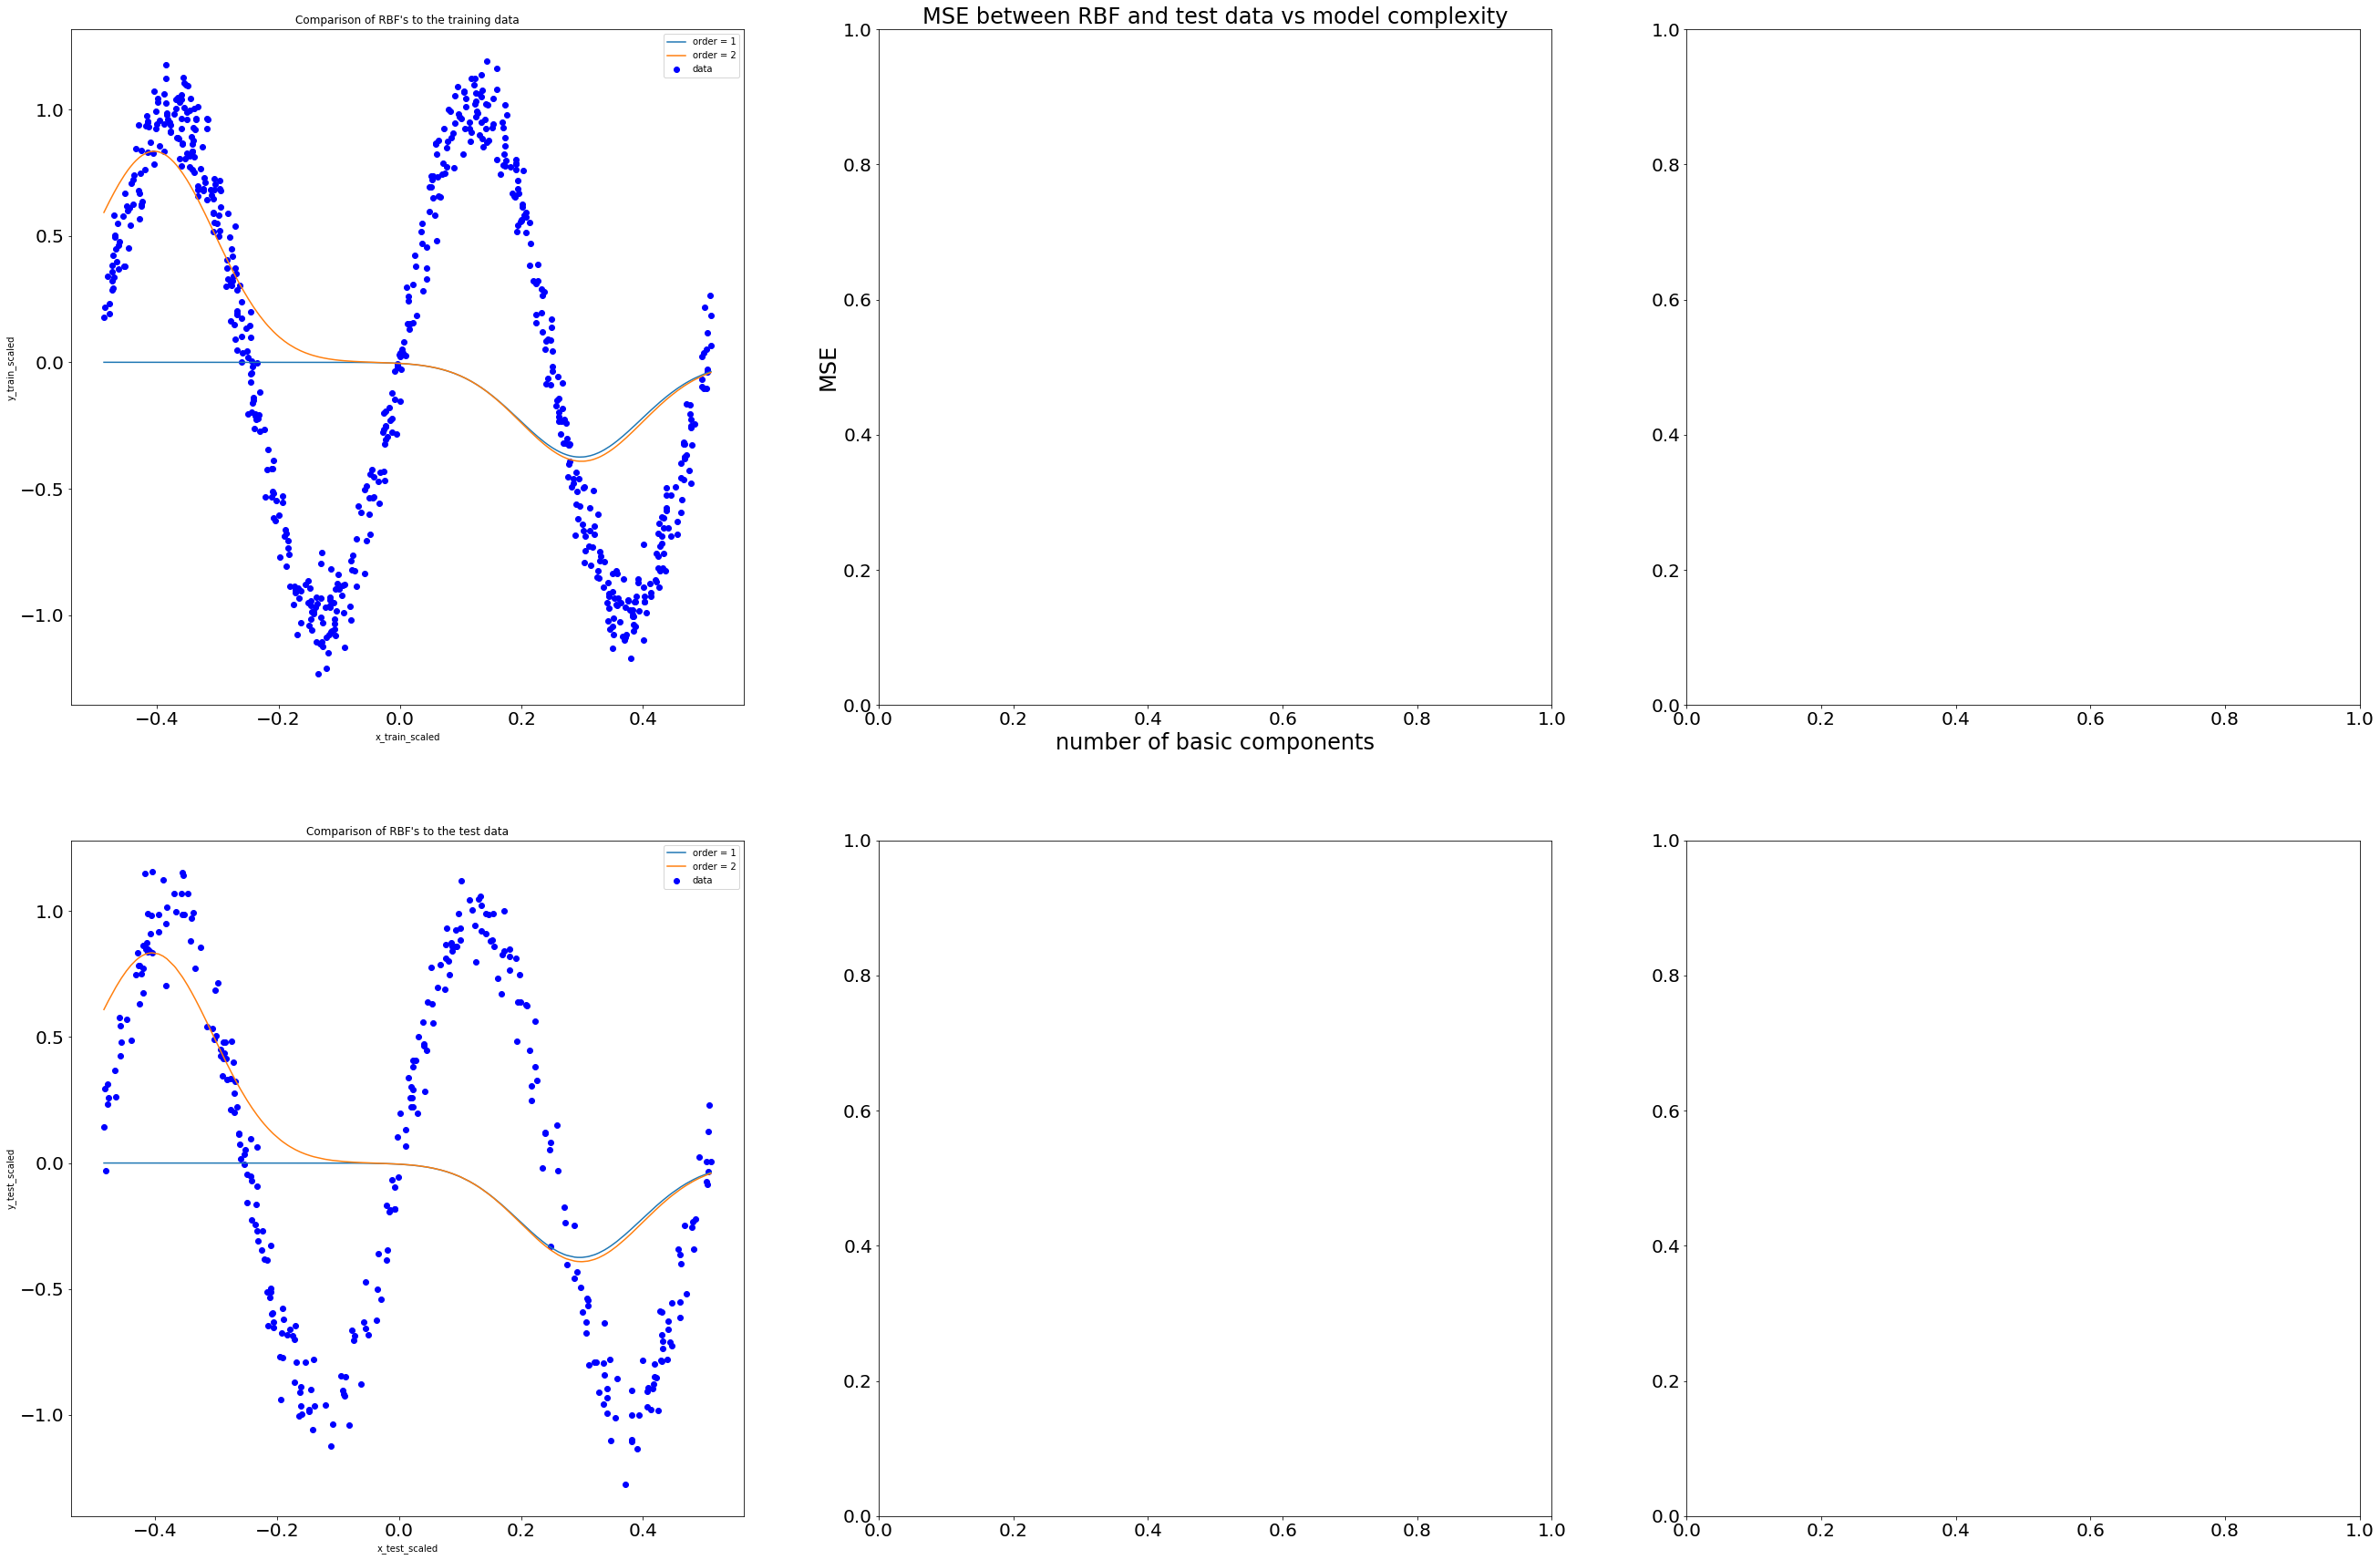

In [114]:
# Plotting RBFs
fig, ax = plt.subplots(figsize=(45,30),nrows=2, ncols=3)

ax[0][0].set(xlabel="x_train_scaled", ylabel="y_train_scaled", title = "Comparison of RBF's to the training data")
ax[0][0].scatter(x_train_scaled, y_train_scaled, c='b', label='data')
ax[1][0].set(xlabel="x_test_scaled", ylabel="y_test_scaled", title = "Comparison of RBF's to the test data")
ax[1][0].scatter(x_test_scaled, y_test_scaled, c='b', label='data')
#ax[0][1].set(xlabel="number of basic components", ylabel="MSE", title = "MSE between RBF and test data vs model complexity")
ax[0][1].set_title(label="MSE between RBF and test data vs model complexity", fontsize=24)
ax[0][1].set_xlabel(xlabel="number of basic components", fontsize=24)
ax[0][1].set_ylabel(ylabel="MSE", fontsize=24)


degree_gauss = 0
lamda_gauss = 10**(-5) # regularisation parameter
u = 25 # number of RBF's to plot
x_j_learnt = []

order_gauss = [i for i in range((degree_gauss+1), (degree_gauss+u+1))]
mse_gauss = []

for i in range(u):
    degree_gauss = degree_gauss + 1
    A_gauss_train = gauss_design(x_train_scaled, degree_gauss) #design matrix of training data
    A_gauss_test = gauss_design_test(x_test_scaled, degree_gauss, x_j_learnt) #design matrix of test data
    w_gauss = calc_weights(A_gauss_train, lamda_gauss, y_train_scaled) 
    
    x_j_learnt = [] #reset x_j_learnt for next iteration
    
    e_gauss_train = error(y_train_scaled, A_gauss_train, w_gauss) #error between model and training data
    e_gauss_test = error(y_test_scaled, A_gauss_test, w_gauss) #error between model and test data
    mse_gauss.append(e_gauss_test[0])
    
    #print("RBFS")
    #print("Order: ", degree_gauss)
    #print("weights: ", w_gauss)
    #print("mse of training data: ", e_gauss_train[0])
    #print("mse of test data: ", e_gauss_test[0])
    #print(" ")
    ax[0][0].plot(x_train_scaled, np.matmul(A_gauss_train, w_gauss), label='order = %d' %degree_gauss)
    ax[1][0].plot(x_test_scaled, np.matmul(A_gauss_test, w_gauss), label='order = %d' %degree_gauss)
ax[0][0].legend()
ax[1][0].legend()

ax[0][1].plot(order_gauss, mse_gauss, c='r', label='data')

degree_best = 15
ax[1][2].set(xlabel="x_test_scaled", ylabel="y_test_scaled", title = "Comparison of model %d for different regulation parameters" %degree_best)
ax[1][2].scatter(x_test_scaled, y_test_scaled, c='b', label='data')
#ax[0][2].set(xlabel="ln(lamda)", ylabel="mse", title = "Comparison of model %d for a range of the complexity parameter" %8)
ax[0][2].set_title(label="Comparison of RBF %d for a range of the regulation parameter" %degree_best, fontsize=24)
ax[0][2].set_xlabel(xlabel="log(Lamda)", fontsize=24)
ax[0][2].set_ylabel(ylabel="MSE", fontsize=24)


reg_param_gauss = [10**(-i) for i in range(2, 8)]
reg_param_gauss.reverse() #for calculating
log_reg_param_gauss = [np.log(10**(-i)) for i in range(2,8)]
log_reg_param_gauss.reverse() #for plotting
mse_reg = []

for i in range(6):
    A_gauss_train = gauss_design(x_train_scaled, degree_best) #design matrix of training data
    A_gauss_test = gauss_design_test(x_test_scaled, degree_best, x_j_learnt) #design matrix of test data
    w_gauss = calc_weights(A_gauss_train, reg_param_gauss[i], y_train_scaled) 
    
    x_j_learnt = [] #reset x_j_learnt for next iteration
    
    e_gauss_train = error(y_train_scaled, A_gauss_train, w_gauss) #error between model and training data
    e_gauss_test = error(y_test_scaled, A_gauss_test, w_gauss) #error between model and test data
    mse_reg.append(e_gauss_test[0])
    
    ax[1][2].plot(x_test_scaled, np.matmul(A_gauss_test, w_gauss), label='log(lamda)= %d' %log_reg_param_gauss[i])

ax[1][2].legend()

# check this plot
ax[0][2].plot(log_reg_param_gauss, mse_reg, c='r', label='data')